<a href="https://colab.research.google.com/github/Abhishek2104200/Wafer-Defects/blob/main/rp2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision transformers timm matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pickle

# Load the dataset
with open('/content/balanced.pkl', 'rb') as f:
    data = pickle.load(f)

# Print available keys
print("Dataset Keys:", data.keys())

# Extract wafer images
X = data['waferMap']  # Wafer maps are your image data
y = data['failureNum']  # Assuming 'failureNum' is the defect label

# Check shapes
print(f"Number of images: {len(X)}, Labels: {len(y)}")


Dataset Keys: Index(['waferMap', 'dieSize', 'lotName', 'trainTestLabel', 'failureType',
       'waferMapDim', 'failureNum', 'trainTestNum'],
      dtype='object')
Number of images: 4000, Labels: 4000


In [ ]:
import numpy as np

In [ ]:
for i in range(5):  # Check first 5 samples
    print(f"Sample {i} type: {type(X[i])}, Shape: {np.array(X[i]).shape if X[i] is not None else 'None'}")


Sample 0 type: <class 'numpy.ndarray'>, Shape: (41, 33)
Sample 1 type: <class 'numpy.ndarray'>, Shape: (44, 41)
Sample 2 type: <class 'numpy.ndarray'>, Shape: (25, 27)
Sample 3 type: <class 'numpy.ndarray'>, Shape: (25, 27)
Sample 4 type: <class 'numpy.ndarray'>, Shape: (31, 31)


In [ ]:
import cv2

filtered_X = []
filtered_y = []

for i in range(len(X)):
    if X[i] is not None and isinstance(X[i], np.ndarray):  # Only keep valid arrays
        img = cv2.resize(X[i], (64, 64))  # Resize to 64x64
        filtered_X.append(img)
        filtered_y.append(y[i])

# Convert to NumPy arrays
X_resized = np.array(filtered_X, dtype=np.float32) / 255.0  # Normalize
y_resized = np.array(filtered_y, dtype=np.int64)

print(f"Final dataset size: {X_resized.shape}, Labels: {y_resized.shape}")


Final dataset size: (4000, 64, 64), Labels: (4000,)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Add channel dimension (1 for grayscale)
X_tensor = torch.tensor(X_resized).unsqueeze(1)  # Shape: (4000, 1, 64, 64)
y_tensor = torch.tensor(y_resized)

# Train-Test Split (80-20)
split = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split], X_tensor[split:]
y_train, y_test = y_tensor[:split], y_tensor[split:]

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 3200, Test size: 800


In [ ]:
import torch.nn as nn
import torch.optim as optim

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x64 → 32x32
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 32x32 → 16x16
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model, optimizer, and loss function
dae = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr=0.001)

# Train Denoising Autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, _ in train_loader:
        noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)  # Add noise
        noisy_inputs = torch.clamp(noisy_inputs, 0., 1.)

        optimizer.zero_grad()
        outputs = dae(noisy_inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/10, Loss: 0.09339612577983644
Epoch 2/10, Loss: 0.0001477944264843245
Epoch 3/10, Loss: 2.5034568288901937e-05
Epoch 4/10, Loss: 1.0915765096797259e-05
Epoch 5/10, Loss: 9.763709804246901e-06
Epoch 6/10, Loss: 8.979529466159875e-06
Epoch 7/10, Loss: 8.794382160886016e-06
Epoch 8/10, Loss: 8.611516745986591e-06
Epoch 9/10, Loss: 8.458841371066228e-06
Epoch 10/10, Loss: 8.287535565614235e-06


In [ ]:
dae.eval()  # Set autoencoder to evaluation mode

X_denoised = []

with torch.no_grad():
    for img in X_tensor:
        img = img.unsqueeze(0)  # Add batch dimension
        denoised_img = dae(img)
        X_denoised.append(denoised_img.squeeze(0).numpy())  # Remove batch dim

X_denoised = np.array(X_denoised)  # Convert to numpy array

print(f"Denoised images shape: {X_denoised.shape}")  # Should be (4000, 1, 64, 64)


Denoised images shape: (4000, 1, 64, 64)


In [ ]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X_denoised, dtype=torch.float32)
y_tensor = torch.tensor(y_resized, dtype=torch.long)

# Train-Test Split (80-20)
split = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split], X_tensor[split:]
y_train, y_test = y_tensor[:split], y_tensor[split:]

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

print(f"Final Training Size: {len(X_train)}, Testing Size: {len(X_test)}")


Final Training Size: 3200, Testing Size: 800


In [ ]:
num_classes = len(set(y_resized))
print("Number of classes:", num_classes)


Number of classes: 8


In [ ]:
print("Unique Train Labels:", np.unique(y_train))
print("Unique Test Labels:", np.unique(y_test))


Unique Train Labels: [0 1 2 3 4 5 6]
Unique Test Labels: [6 8]


In [ ]:
# Correct label mapping BEFORE splitting
label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(set(y_resized)))}
y_resized = np.array([label_mapping[label] for label in y_resized])  # Apply mapping correctly

# Verify again
print("Updated Unique Labels:", np.unique(y_resized))  # Should be [0 1 2 3 4 5 6 7]


Updated Unique Labels: [0 1 2 3 4 5 6 7]


In [ ]:
from sklearn.model_selection import train_test_split

# Ensure the split is done AFTER fixing labels
X_train, X_test, y_train, y_test = train_test_split(X_denoised, y_resized, test_size=0.2, stratify=y_resized, random_state=42)

# Verify labels again
print("Fixed Unique Train Labels:", np.unique(y_train))  # Should be [0 1 2 3 4 5 6 7]
print("Fixed Unique Test Labels:", np.unique(y_test))  # Should be [0 1 2 3 4 5 6 7]


Fixed Unique Train Labels: [0 1 2 3 4 5 6 7]
Fixed Unique Test Labels: [0 1 2 3 4 5 6 7]


In [ ]:
print("Unique Train Labels:", np.unique(y_train))
print("Unique Test Labels:", np.unique(y_test))


Unique Train Labels: [0 1 2 3 4 5 6 7]
Unique Test Labels: [0 1 2 3 4 5 6 7]


In [ ]:
import torch.nn as nn
from torchvision import models
from transformers import ViTModel, ViTConfig

# CNN Backbone (MobileNetV2)
cnn_model = models.mobilenet_v2(pretrained=True)
cnn_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Adjust for grayscale input

# Vision Transformer (ViT)
vit_config = ViTConfig(image_size=64, num_channels=1, num_labels=len(set(y_resized)), hidden_size=768)
vit_model = ViTModel(vit_config)

# Hybrid Model
class HybridCNNViT(nn.Module):
    def __init__(self, cnn_model, vit_model, num_classes):
        super(HybridCNNViT, self).__init__()
        self.cnn = cnn_model.features
        self.vit = vit_model
        self.fc = nn.Linear(vit_config.hidden_size, num_classes)

    def forward(self, x):
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.view(cnn_features.size(0), -1)
        vit_output = self.vit(pixel_values=x).last_hidden_state[:, 0, :]
        combined_features = cnn_features + vit_output
        output = self.fc(combined_features)
        return output

# Initialize the model
model = HybridCNNViT(cnn_model, vit_model, num_classes=len(set(y_resized)))

print("Hybrid model initialized successfully!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 92.7MB/s]


Hybrid model initialized successfully!


In [ ]:
import torch.nn as nn

class HybridCNNViT(nn.Module):
    def __init__(self, cnn_model, vit_model, num_classes):
        super(HybridCNNViT, self).__init__()
        self.cnn = cnn_model.features  # Extract CNN features
        self.vit = vit_model  # Extract ViT features

        # Reduce CNN output size to 768 using a linear layer
        self.cnn_fc = nn.Linear(20480, 768)

        # Fully Connected Layer for Classification
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        # CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.view(cnn_features.size(0), -1)  # Flatten
        cnn_features = self.cnn_fc(cnn_features)  # Reduce to 768

        # ViT Feature Extraction
        vit_output = self.vit(pixel_values=x).last_hidden_state[:, 0, :]  # CLS token output

        # Combine CNN & ViT Features
        combined_features = cnn_features + vit_output
        output = self.fc(combined_features)  # Classification

        return output

# Initialize the model
num_classes = len(set(y_resized))
model = HybridCNNViT(cnn_model, vit_model, num_classes)

print("Fixed Hybrid CNN + ViT Model Ready!")


Fixed Hybrid CNN + ViT Model Ready!


In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")


Epoch 1/15, Loss: 5.9885, Train Acc: 49.16%
Epoch 2/15, Loss: 2.8571, Train Acc: 57.62%
Epoch 3/15, Loss: 1.5133, Train Acc: 62.56%
Epoch 4/15, Loss: 0.7357, Train Acc: 73.47%
Epoch 5/15, Loss: 0.6063, Train Acc: 77.31%
Epoch 6/15, Loss: 0.5527, Train Acc: 80.41%
Epoch 7/15, Loss: 0.5323, Train Acc: 80.31%
Epoch 8/15, Loss: 0.4630, Train Acc: 83.09%
Epoch 9/15, Loss: 0.4400, Train Acc: 83.72%
Epoch 10/15, Loss: 0.3842, Train Acc: 85.69%
Epoch 11/15, Loss: 0.3840, Train Acc: 86.16%
Epoch 12/15, Loss: 0.3394, Train Acc: 87.81%
Epoch 13/15, Loss: 0.3392, Train Acc: 88.03%
Epoch 14/15, Loss: 0.3037, Train Acc: 88.50%
Epoch 15/15, Loss: 0.2841, Train Acc: 90.25%


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 82.75%


In [ ]:
print("Unique Test Labels:", np.unique(y_test))  # Should be [0 1 2 3 4 5 6 7]


Unique Test Labels: [0 1 2 3 4 5 6 7]


In [ ]:
model.fc = nn.Linear(768, 8)


In [ ]:
del model
del optimizer
torch.cuda.empty_cache()  # Free GPU memory


In [ ]:
model = HybridCNNViT(cnn_model, vit_model, num_classes=8)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)


In [ ]:
# 1️⃣ Reset & reinitialize the model
del model
del optimizer
torch.cuda.empty_cache()  # Free GPU memory

# Reinitialize model & optimizer
model = HybridCNNViT(cnn_model, vit_model, num_classes=8)  # Ensure output is 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Loss function

# 2️⃣ Track losses for visualization
train_losses = []
test_losses = []

# 3️⃣ Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation (compute gradients)
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)  # Get predicted class
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)

    # Compute training accuracy
    train_acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))  # Store train loss

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")




Epoch 1/20, Loss: 5.5781, Train Acc: 39.62%
Epoch 2/20, Loss: 1.6277, Train Acc: 54.47%
Epoch 3/20, Loss: 1.7609, Train Acc: 53.75%
Epoch 4/20, Loss: 1.0081, Train Acc: 64.25%
Epoch 5/20, Loss: 0.8867, Train Acc: 67.72%
Epoch 6/20, Loss: 0.8275, Train Acc: 72.09%
Epoch 7/20, Loss: 0.7433, Train Acc: 74.75%
Epoch 8/20, Loss: 0.6879, Train Acc: 76.28%
Epoch 9/20, Loss: 0.6509, Train Acc: 77.84%
Epoch 10/20, Loss: 0.6130, Train Acc: 79.06%
Epoch 11/20, Loss: 0.5861, Train Acc: 79.78%
Epoch 12/20, Loss: 0.5913, Train Acc: 78.66%
Epoch 13/20, Loss: 0.6613, Train Acc: 76.84%
Epoch 14/20, Loss: 0.5600, Train Acc: 81.31%
Epoch 15/20, Loss: 0.5007, Train Acc: 83.19%
Epoch 16/20, Loss: 0.4682, Train Acc: 83.62%
Epoch 17/20, Loss: 0.4461, Train Acc: 84.53%
Epoch 18/20, Loss: 0.4217, Train Acc: 85.34%
Epoch 19/20, Loss: 0.3682, Train Acc: 86.44%
Epoch 20/20, Loss: 0.3586, Train Acc: 87.25%


In [ ]:
import numpy as np

model.eval()
class_correct = np.zeros(8)  # Number of classes = 8
class_total = np.zeros(8)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        for i in range(len(labels)):
            class_correct[labels[i]] += (predicted[i] == labels[i]).item()
            class_total[labels[i]] += 1

# Print per-class accuracy
for i in range(8):
    if class_total[i] > 0:
        print(f"Class {i}: Accuracy {100 * class_correct[i] / class_total[i]:.2f}%")
    else:
        print(f"Class {i}: No samples in test set")


Class 0: Accuracy 89.00%
Class 1: Accuracy 96.00%
Class 2: Accuracy 61.00%
Class 3: Accuracy 75.00%
Class 4: Accuracy 94.00%
Class 5: Accuracy 86.00%
Class 6: Accuracy 76.00%
Class 7: Accuracy 0.00%


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create fresh DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

print("DataLoaders successfully reset!")


DataLoaders successfully reset!


In [ ]:
print("Final Unique Test Labels:", torch.unique(y_test_tensor))  # Should be [0 1 2 3 4 5 6 7]


Final Unique Test Labels: tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 72.12%


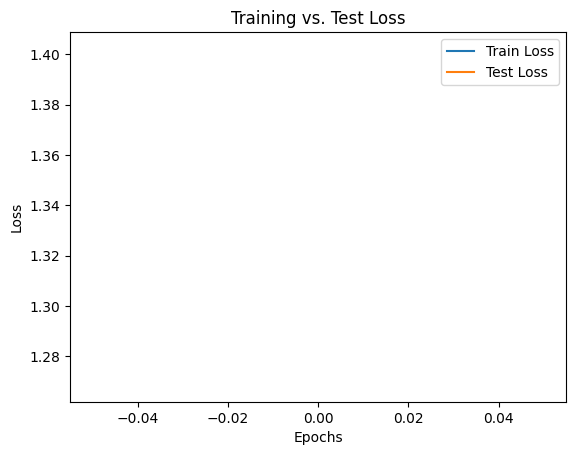

In [ ]:
import matplotlib.pyplot as plt

# Store test losses
test_losses = []

# Move model to evaluation mode
model.eval()

with torch.no_grad():
    total_loss = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

    test_losses.append(total_loss / len(test_loader))

# Plot training vs. test loss curves
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()
plt.show()


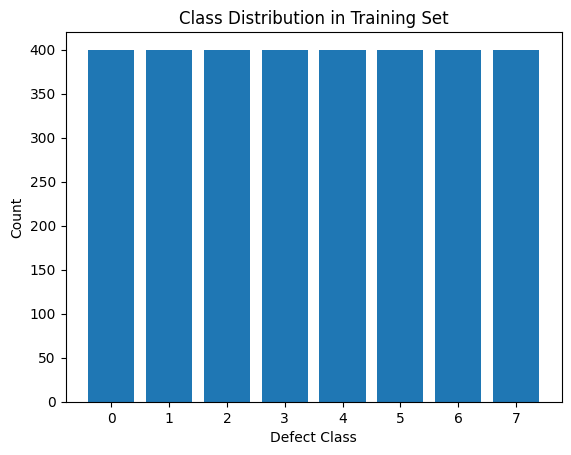

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Defect Class")
plt.ylabel("Count")
plt.title("Class Distribution in Training Set")
plt.show()


In [ ]:
torch.save(model.state_dict(), "hybrid_cnn_vit72.pth")
print("Model saved successfully!")


Model saved successfully!


**3**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch

# Initialize the model again with the same architecture
model = HybridCNNViT(cnn_model, vit_model, num_classes=8)  # Ensure output is 8

# Load saved weights
model.load_state_dict(torch.load("hybrid_cnn_vit.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

# Set model to evaluation mode
model.eval()

print("Model loaded successfully!")


<ipython-input-21-0229f05eb119>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hybrid_cnn_vit.pth", map_location=torch.device("cuda" if t

Model loaded successfully!
